# **IMPORT & LOAD DATASET**

In [3]:
import os
import sys
import math
import zipfile
import requests
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.stats import randint, uniform
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.stats import randint, uniform
from tensorflow.keras.applications.xception import preprocess_input


In [4]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
dataset_path = r"C:\Users\Siti Vanesa Rahma\Documents\dataset"
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_1.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_10.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_100.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_101.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_102.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_103.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_104.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_105.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_106.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_107.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_108.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_109.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_11.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_110.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset\fake\frame_111.jpg
C:\Users\Siti Vanesa Rahma\Documents\dataset

In [6]:
fake_folder = r"C:\Users\Siti Vanesa Rahma\Documents\dataset\fake"
real_folder = r"C:\Users\Siti Vanesa Rahma\Documents\dataset\real3"

# **PREPROCESSING & EKSPLORASI DATA**

In [7]:
def label_images(fake_folder, real_folder):
    data = []

    # Label images sebagai fake
    for img_file in os.listdir(fake_folder):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(fake_folder, img_file)
            data.append({'image_path': img_path, 'label': 'fake'})

    # Label images sebagai real
    for img_file in os.listdir(real_folder):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(real_folder, img_file)
            data.append({'image_path': img_path, 'label': 'real'})

    return data

labeled_data = label_images(fake_folder, real_folder)
print(labeled_data)

[{'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Documents\\dataset\\fake\\frame_1.jpg', 'label': 'fake'}, {'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Documents\\dataset\\fake\\frame_10.jpg', 'label': 'fake'}, {'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Documents\\dataset\\fake\\frame_100.jpg', 'label': 'fake'}, {'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Documents\\dataset\\fake\\frame_101.jpg', 'label': 'fake'}, {'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Documents\\dataset\\fake\\frame_102.jpg', 'label': 'fake'}, {'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Documents\\dataset\\fake\\frame_103.jpg', 'label': 'fake'}, {'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Documents\\dataset\\fake\\frame_104.jpg', 'label': 'fake'}, {'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Documents\\dataset\\fake\\frame_105.jpg', 'label': 'fake'}, {'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Documents\\dataset\\fake\\frame_106.jpg', 'label': 'fake'}, {'image_path': 'C:\\Users\\Siti Vanesa Rahma\\Do

Label Distribution:
fake: 567
real: 516


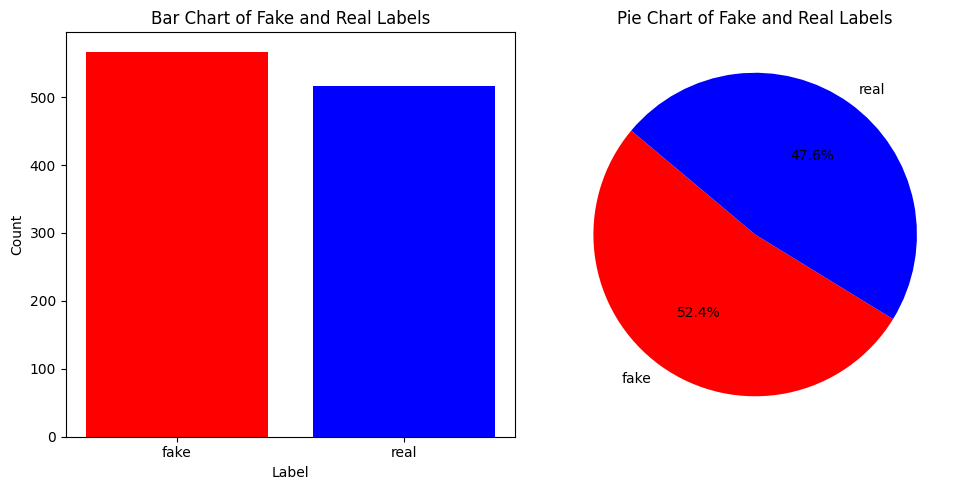

In [8]:
#Visualisasi jumlah data
def display_label_distribution(data):
    label_counts = Counter(item['label'] for item in data)

    print("Label Distribution:")
    for label, count in label_counts.items():
        print(f"{label}: {count}")

    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.bar(labels, counts, color=['red', 'blue'])
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title("Bar Chart of Fake and Real Labels")

    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['red', 'blue'], startangle=140)
    plt.title("Pie Chart of Fake and Real Labels")

    plt.tight_layout()
    plt.show()

display_label_distribution(labeled_data)

In [9]:
pip install tensorflow-addons



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 2)


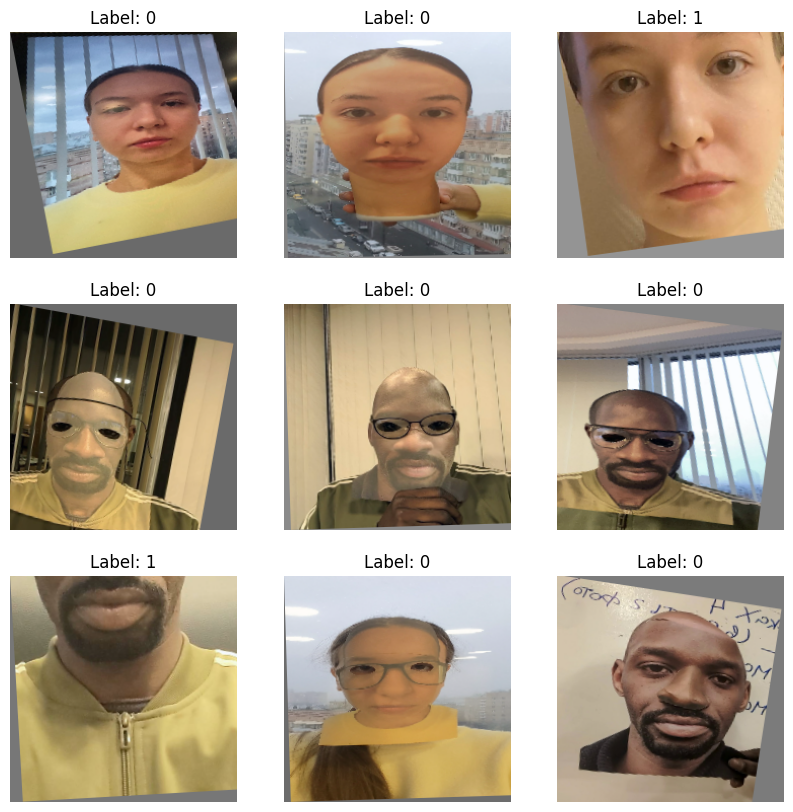

In [10]:
# Inisialisasi list untuk penyimpanan nama file dan labelnya
file_paths = []
labels = []

# Load dataset
for class_index, class_name in enumerate(os.listdir(dataset_path)):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for image_filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_filename)
            file_paths.append(image_path)
            labels.append(class_index)

# Split data menjadi 60% training and 40% temporary set(validation + testing)
file_paths_train, file_paths_temp, labels_train, labels_temp = train_test_split(
    file_paths, labels, test_size=0.4, stratify=labels, random_state=42
)

# Split data temporary menjadi 50% test dan 50& validasi
file_paths_val, file_paths_test, labels_val, labels_test = train_test_split(
    file_paths_temp, labels_temp, test_size=0.5, stratify=labels_temp, random_state=42
)

input_shape = (224, 224, 3)
num_classes = 2

# Preprocessing
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, input_shape[:2]) 
    image = preprocess_input(image)  
    label = tf.one_hot(label, num_classes) 
    return image, label

# Fungsi augmentasi untuk memperbanyak keragaman data
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast
    
    # Custom random rotation
    def random_rotation(image):
        angle = tf.random.uniform([], -0.2, 0.2) 
        cos_theta = tf.math.cos(angle)
        sin_theta = tf.math.sin(angle)

        transform = [cos_theta, sin_theta, 0.0, -sin_theta, cos_theta, 0.0, 0.0, 0.0]
        transform = tf.convert_to_tensor(transform)
        transform = tf.reshape(transform, [1, 8])

        image = tf.expand_dims(image, 0)  
        rotated_image = tf.raw_ops.ImageProjectiveTransformV3(
            images=image,
            transforms=transform,
            output_shape=tf.shape(image)[1:3],
            interpolation='BILINEAR',
            fill_value=0.0  
        )
        return tf.squeeze(rotated_image)  

    image = random_rotation(image)
    return image, label

batch_size = 32

# Training Dataset
train_generator = tf.data.Dataset.from_tensor_slices((file_paths_train, labels_train))
train_generator = (
    train_generator.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) 
    .shuffle(len(file_paths_train))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Validation Dataset
validation_generator = tf.data.Dataset.from_tensor_slices((file_paths_val, labels_val))
validation_generator = (
    validation_generator.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Test Dataset
test_generator = tf.data.Dataset.from_tensor_slices((file_paths_test, labels_test))
test_generator = (
    test_generator.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Cetak struktur dataset
for images, labels in train_generator.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    # Visualisasi datasetnya
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]))
        plt.title(f"Label: {tf.argmax(labels[i]).numpy()}")
        plt.axis("off")
    plt.show()

In [11]:
# Cetak jumllah data pada pelatihan, test, dan validasi
print(f"Number of training images: {len(file_paths_train)}")
print(f"Number of validation images: {len(file_paths_val)}")
print(f"Number of test images: {len(file_paths_test)}")


Number of training images: 649
Number of validation images: 217
Number of test images: 217


# **EKSPLORASI MODEL 1**

In [13]:
# Pembuatan model CNN dengan arsitektur Xception
def build_and_compile_model(input_shape, num_classes):
    base_model = Xception(include_top=False, weights='imagenet', input_shape = (224, 224, 3))

    base_model.trainable = False

    x = base_model.output
    x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)


    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Jalankan fungsi build_and_compile_model
model = build_and_compile_model(input_shape, num_classes)

model.summary()

# EarlyStopping dan ReduceLROnPlateau untuk menghindari overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 111, 111, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 111, 111, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 111, 111, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 109, 109, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 109, 109, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 109, 109, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 109, 109, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 109, 109, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 109, 109, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 109, 109, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 109, 109, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 55, 55, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 55, 55, 128)       │               

 Total params: 21,578,122 (82.31 MB)

 Trainable params: 716,194 (2.73 MB)

 Non-trainable params: 20,861,928 (79.58 MB)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7724 - loss: 0.5819 - val_accuracy: 0.7235 - val_loss: 0.8451 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9681 - loss: 0.0895 - val_accuracy: 1.0000 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9910 - loss: 0.0392 - val_accuracy: 0.9908 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9912 - loss: 0.0306 - val_accuracy: 0.9908 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9917 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9977 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9878 - loss: 0.0196 - val_accuracy: 

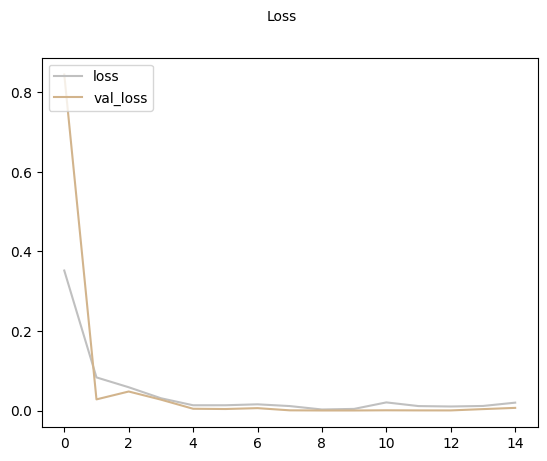

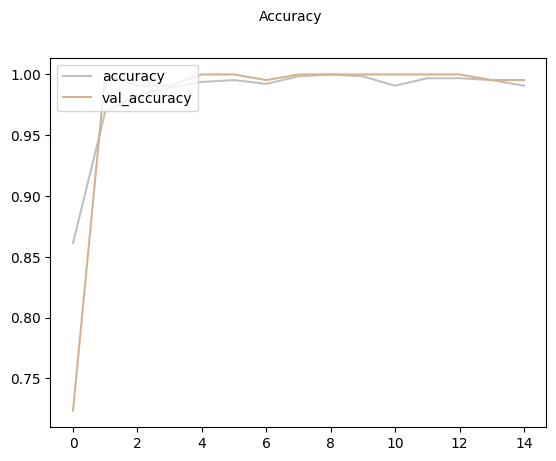

In [14]:
#Visualisasi proses training
fig = plt.figure()
plt.plot(history.history['loss'], color='silver', label='loss')
plt.plot(history.history['val_loss'], color='tan', label='val_loss')
plt.suptitle('Loss', fontsize=10)
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='silver', label='accuracy')
plt.plot(history.history['val_accuracy'], color='tan', label='val_accuracy')
plt.suptitle('Accuracy', fontsize=10)
plt.legend(loc='upper left')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - accuracy: 1.0000 - loss: 8.7120e-05
Validation Loss: 0.00013557853526435792
Validation Accuracy: 1.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 937ms/step


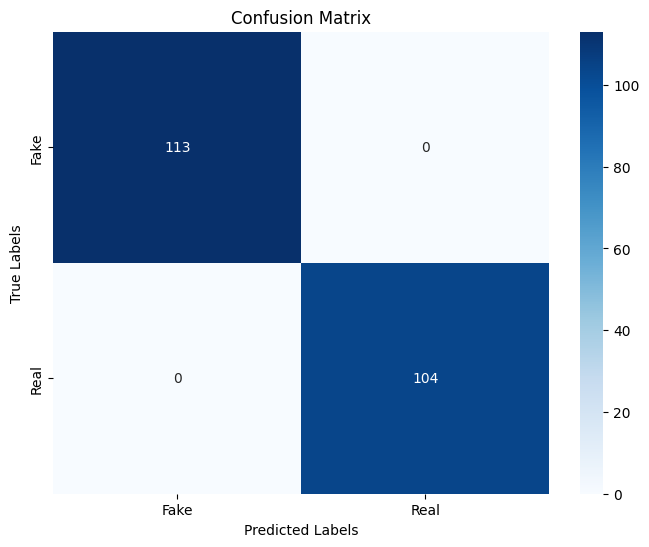

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       113
        Real       1.00      1.00      1.00       104

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



In [15]:
# Melakukan evaluasi model  untuk data validasi
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

y_true = []
for _, labels in validation_generator:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

class_names = ['Fake', 'Real']  

confusion_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(class_report)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 837ms/step - accuracy: 1.0000 - loss: 3.4518e-05
Test Loss: 4.715240720543079e-05
Test Accuracy: 1.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 828ms/step


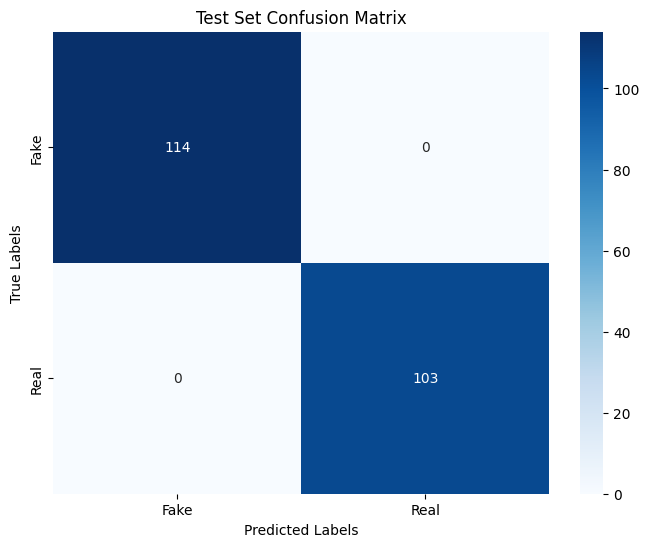

Test Set Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       114
        Real       1.00      1.00      1.00       103

    accuracy                           1.00       217
   macro avg       1.00      1.00      1.00       217
weighted avg       1.00      1.00      1.00       217



In [16]:
# Melakukan evaluasi model  untuk data testing
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_true_test = []
for _, labels in test_generator:
    y_true_test.extend(np.argmax(labels.numpy(), axis=1)) 
y_true_test = np.array(y_true_test)

y_pred_test = model.predict(test_generator)
y_pred_test = np.argmax(y_pred_test, axis=1)

class_names = ['Fake', 'Real']

confusion_mat_test = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

class_report_test = classification_report(y_true_test, y_pred_test, target_names=class_names)
print("Test Set Classification Report:")
print(class_report_test)

# **FEATURE ENGINEERING (MANUAL)**

In [30]:
# fungsi melakukan resize gambar
def resize_image(image, size=(128, 128)):
    return cv.resize(image, size)

# fungsi ekstrak fitur textur
def extract_texture(image):
    if isinstance(image, tf.Tensor):
        image = image.numpy()  
    gray_image = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, 24, 3, method="uniform")
    hist = np.histogram(lbp.ravel(), bins=np.arange(0, 26), range=(0, 25))[0]
    return hist / np.sum(hist) 

# fungsi ekstrak fitur bentuk
def extract_shape(image):
    gray_image = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray_image, 100, 200)
    return edges.flatten().astype("float32")

# fungsi ekstrak fitur warna
def extract_color(image):
    hsv_image = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_BGR2HSV)
    hist = cv.calcHist([hsv_image], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    return hist.flatten().astype("float32")

# fungsi ekstrak fitur tekstur-bentuk
def extract_texture_shape(image):
    texture = extract_texture(image)
    shape = extract_shape(image)
    return np.hstack([texture, shape])

# fungsi ekstrak fitur tekstur-warna
def extract_texture_color(image):
    texture = extract_texture(image)
    color = extract_color(image)
    return np.hstack([texture, color])

# fungsi ekstrak fitur bentuk-warna
def extract_shape_color(image):
    shape = extract_shape(image)
    color = extract_color(image)
    return np.hstack([shape, color])

# fungsi ekstrak fitur tekstur-bentuk-warna
def extract_texture_shape_color(image):
    texture = extract_texture(image)
    shape = extract_shape(image)
    color = extract_color(image)
    return np.hstack([texture, shape, color])

# Ekstrak fitur
def extract_features(generator, feature_combination):
    features = []
    labels = []

    iterator = iter(generator)

    try:
        while True:
            batch_images, batch_labels = next(iterator)

            for img, lbl in zip(batch_images, batch_labels):
                if isinstance(img, tf.Tensor): 
                    img = img.numpy()

                if feature_combination == "texture":
                    features.append(extract_texture(img))
                elif feature_combination == "shape":
                    features.append(extract_shape(img))
                elif feature_combination == "color":
                    features.append(extract_color(img))
                elif feature_combination == "texture_shape":
                    features.append(np.concatenate([extract_texture(img), extract_shape(img)]))
                elif feature_combination == "texture_color":
                    features.append(np.concatenate([extract_texture(img), extract_color(img)]))
                elif feature_combination == "shape_color":
                    features.append(np.concatenate([extract_shape(img), extract_color(img)]))
                elif feature_combination == "texture_shape_color":
                    features.append(np.concatenate([extract_texture(img), extract_shape(img), extract_color(img)]))
                else:
                    raise ValueError(f"Unknown feature combination: {feature_combination}")

                labels.append(np.argmax(lbl))  

    except StopIteration:
        pass  

    return np.array(features), np.array(labels)


# **EKSPLORASI MODEL 2, 3, 4 (PART 2)**


### Processing Feature Combination: TEXTURE ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 39, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 253}
Random Forest Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.80      0.91      0.85       113
        Real       0.89      0.75      0.81       104

    accuracy                           0.83       217
   macro avg       0.84      0.83      0.83       217
weighted avg       0.84      0.83      0.83       217



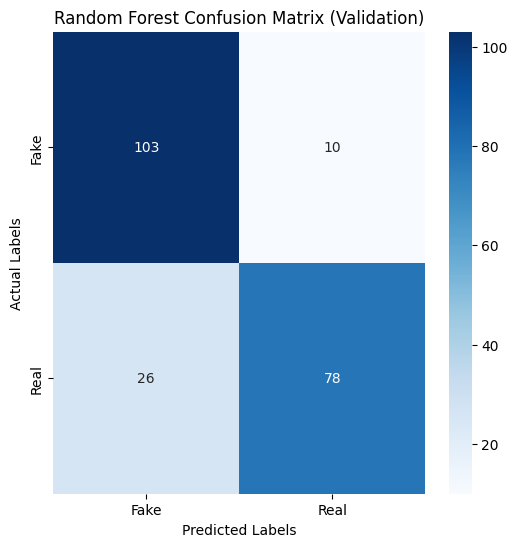


### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Logistic Regression Parameters: {'C': np.float64(1.6601864044243653), 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.83      0.89      0.86       113
        Real       0.87      0.80      0.83       104

    accuracy                           0.85       217
   macro avg       0.85      0.85      0.85       217
weighted avg       0.85      0.85      0.85       217



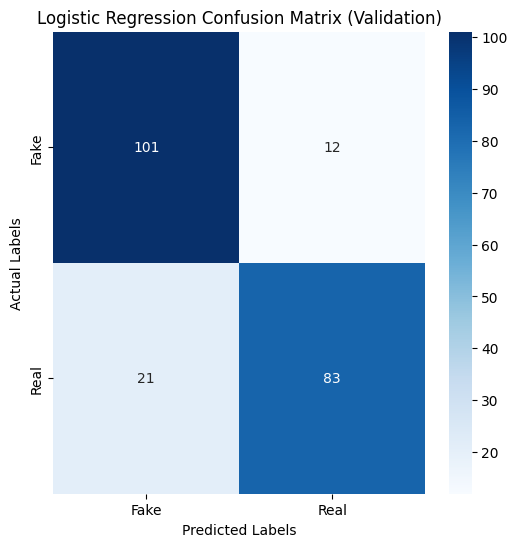


### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'C': np.float64(7.896910002727692), 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.85      0.92      0.89       113
        Real       0.91      0.83      0.86       104

    accuracy                           0.88       217
   macro avg       0.88      0.87      0.87       217
weighted avg       0.88      0.88      0.88       217



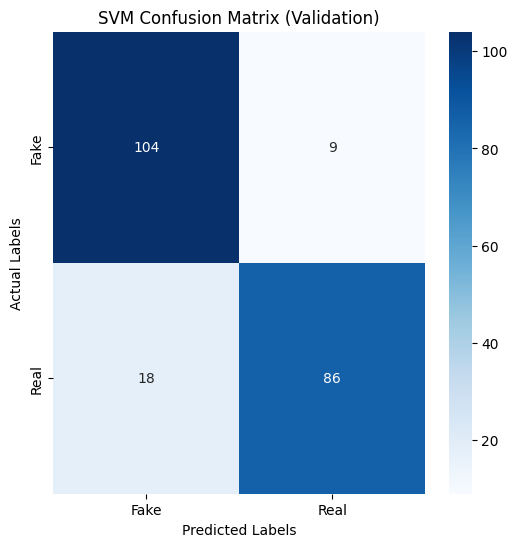


### Final Evaluation on Test Data ###
Random Forest Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.75      0.92      0.83       114
        Real       0.88      0.66      0.76       103

    accuracy                           0.80       217
   macro avg       0.82      0.79      0.79       217
weighted avg       0.81      0.80      0.79       217



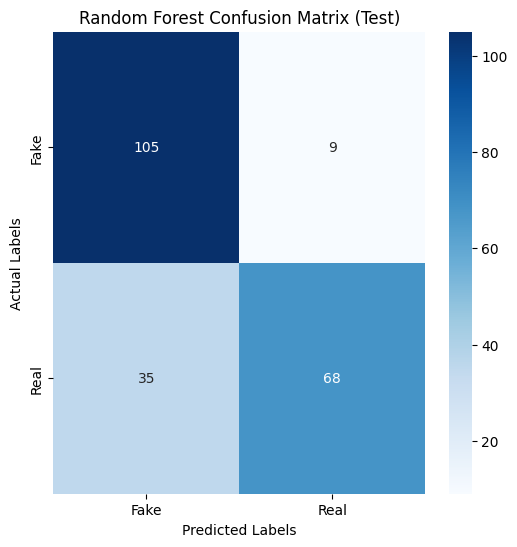

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.76      0.98      0.85       114
        Real       0.97      0.65      0.78       103

    accuracy                           0.82       217
   macro avg       0.86      0.82      0.82       217
weighted avg       0.86      0.82      0.82       217



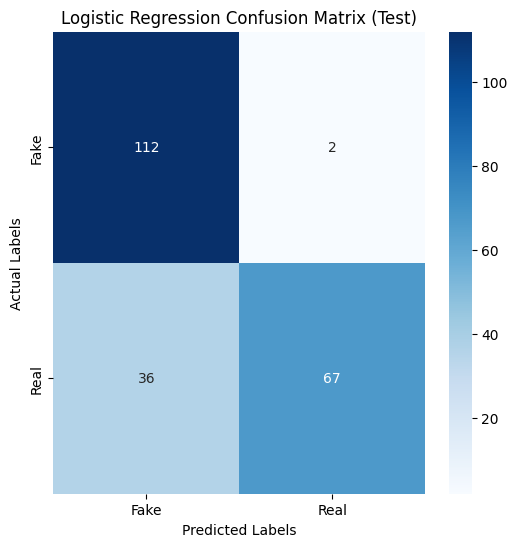

SVM Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.80      0.97      0.88       114
        Real       0.96      0.73      0.83       103

    accuracy                           0.86       217
   macro avg       0.88      0.85      0.85       217
weighted avg       0.88      0.86      0.85       217



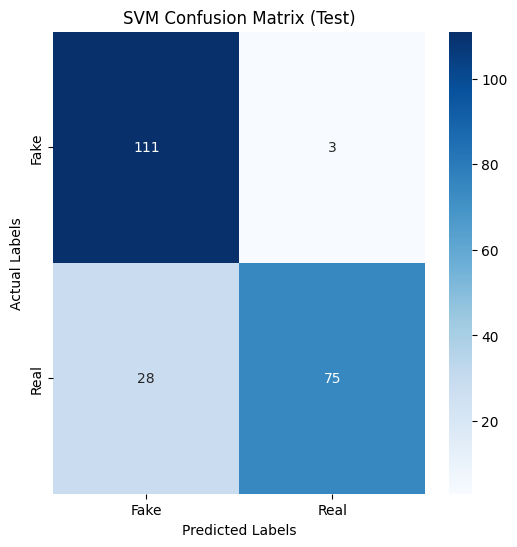


### Processing Feature Combination: SHAPE ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 39, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 253}
Random Forest Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.81      0.92      0.86       113
        Real       0.90      0.77      0.83       104

    accuracy                           0.85       217
   macro avg       0.86      0.84      0.85       217
weighted avg       0.85      0.85      0.85       217



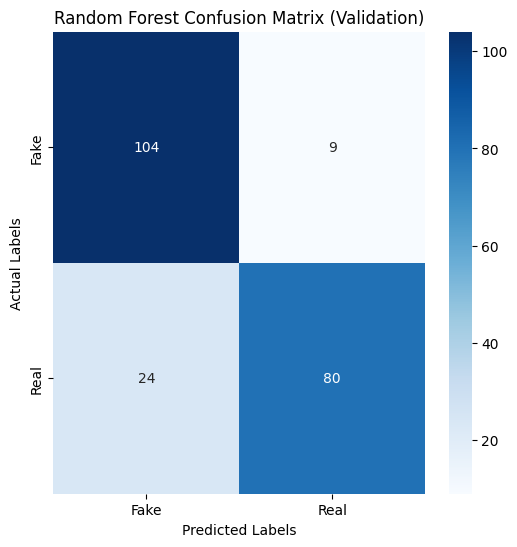


### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Logistic Regression Parameters: {'C': np.float64(0.6808361216819946), 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.91      0.91      0.91       113
        Real       0.90      0.90      0.90       104

    accuracy                           0.91       217
   macro avg       0.91      0.91      0.91       217
weighted avg       0.91      0.91      0.91       217



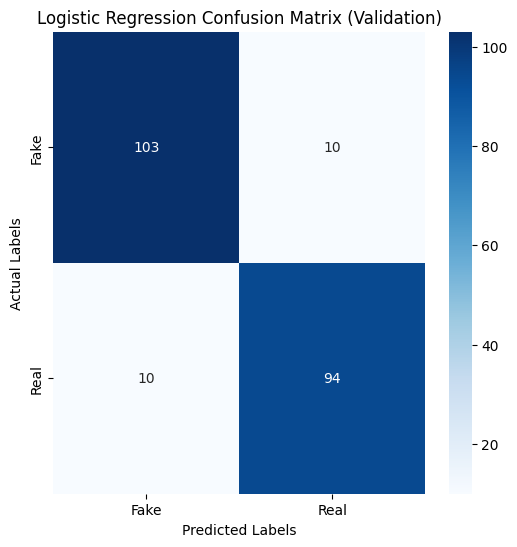


### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'C': np.float64(1.6599452033620266), 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.88      0.91      0.90       113
        Real       0.90      0.87      0.88       104

    accuracy                           0.89       217
   macro avg       0.89      0.89      0.89       217
weighted avg       0.89      0.89      0.89       217



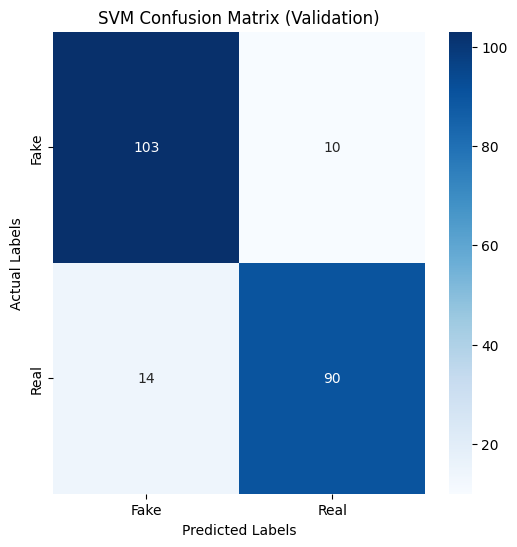


### Final Evaluation on Test Data ###
Random Forest Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.87      0.91      0.89       114
        Real       0.90      0.84      0.87       103

    accuracy                           0.88       217
   macro avg       0.88      0.88      0.88       217
weighted avg       0.88      0.88      0.88       217



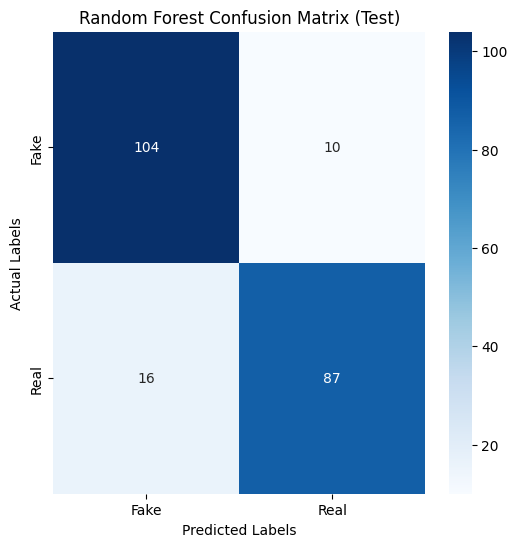

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95       114
        Real       0.94      0.94      0.94       103

    accuracy                           0.94       217
   macro avg       0.94      0.94      0.94       217
weighted avg       0.94      0.94      0.94       217



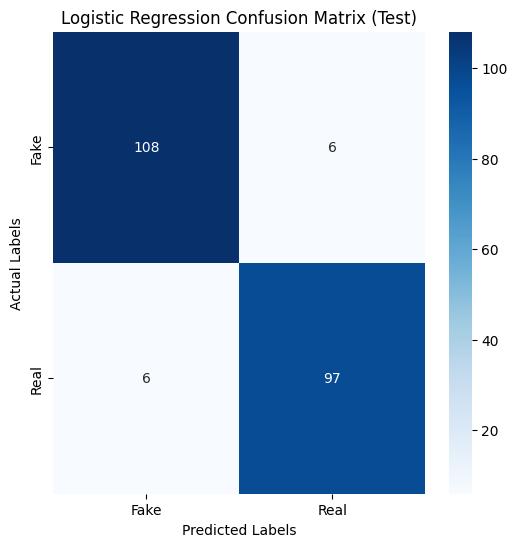

SVM Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.95      0.94       114
        Real       0.94      0.92      0.93       103

    accuracy                           0.94       217
   macro avg       0.94      0.93      0.94       217
weighted avg       0.94      0.94      0.94       217



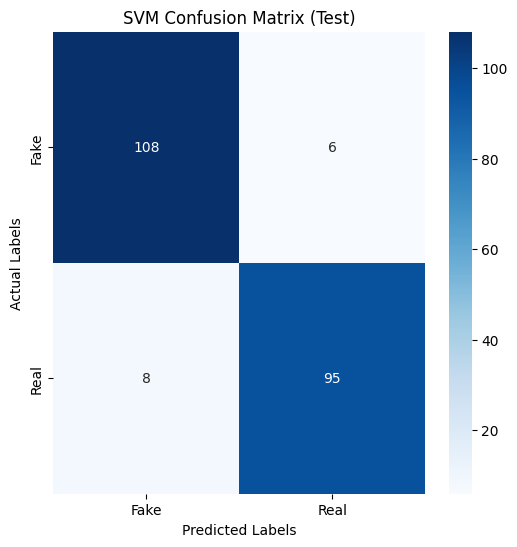


### Processing Feature Combination: COLOR ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 39, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 253}
Random Forest Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.97      0.94      0.95       113
        Real       0.94      0.97      0.95       104

    accuracy                           0.95       217
   macro avg       0.95      0.95      0.95       217
weighted avg       0.95      0.95      0.95       217



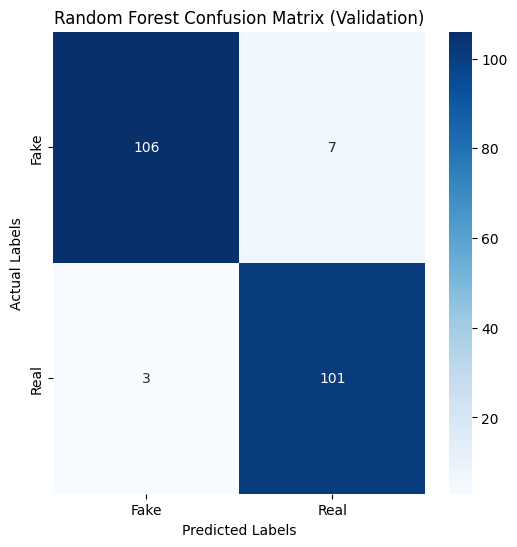


### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Logistic Regression Parameters: {'C': np.float64(1.6601864044243653), 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.97      0.85      0.91       113
        Real       0.86      0.97      0.91       104

    accuracy                           0.91       217
   macro avg       0.91      0.91      0.91       217
weighted avg       0.92      0.91      0.91       217



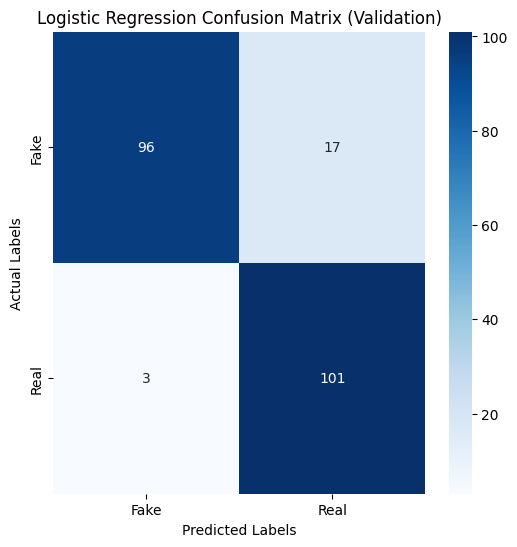


### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'C': np.float64(7.896910002727692), 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.95      0.92      0.93       113
        Real       0.92      0.94      0.93       104

    accuracy                           0.93       217
   macro avg       0.93      0.93      0.93       217
weighted avg       0.93      0.93      0.93       217



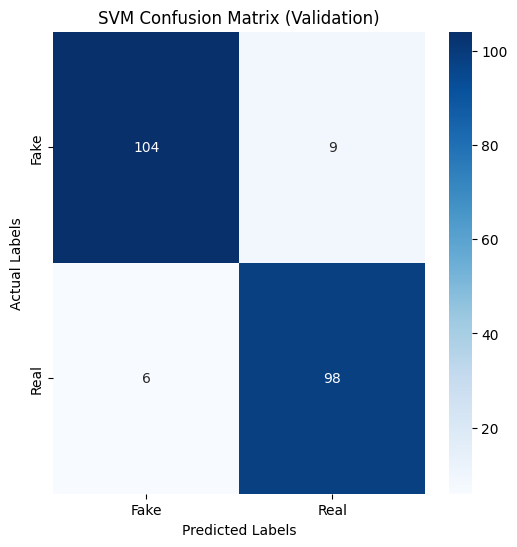


### Final Evaluation on Test Data ###
Random Forest Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.96      0.98       114
        Real       0.96      0.99      0.98       103

    accuracy                           0.98       217
   macro avg       0.98      0.98      0.98       217
weighted avg       0.98      0.98      0.98       217



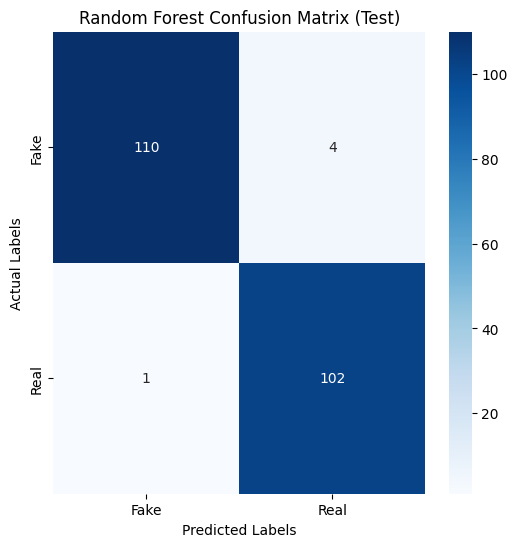

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.83      0.89       114
        Real       0.84      0.96      0.90       103

    accuracy                           0.89       217
   macro avg       0.90      0.90      0.89       217
weighted avg       0.90      0.89      0.89       217



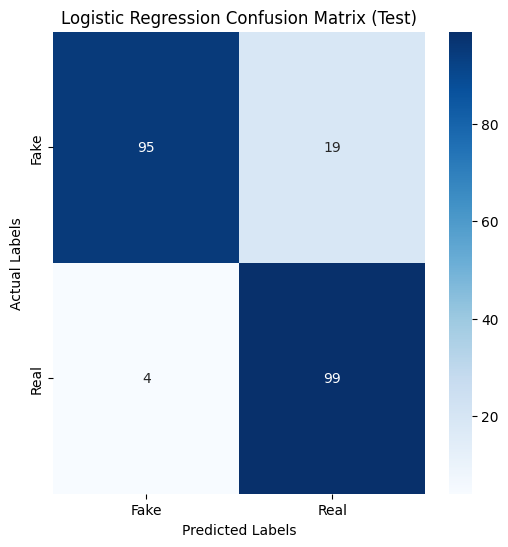

SVM Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.91      0.94      0.93       114
        Real       0.93      0.90      0.92       103

    accuracy                           0.92       217
   macro avg       0.92      0.92      0.92       217
weighted avg       0.92      0.92      0.92       217



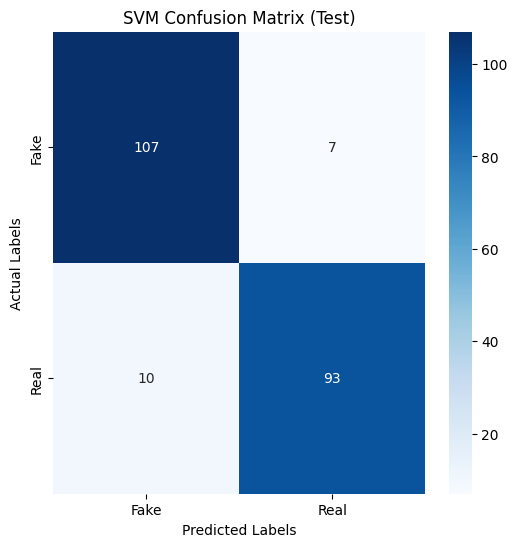


### Processing Feature Combination: TEXTURE_SHAPE ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 18, 'n_estimators': 268}
Random Forest Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.70      0.96      0.81       113
        Real       0.92      0.55      0.69       104

    accuracy                           0.76       217
   macro avg       0.81      0.75      0.75       217
weighted avg       0.80      0.76      0.75       217



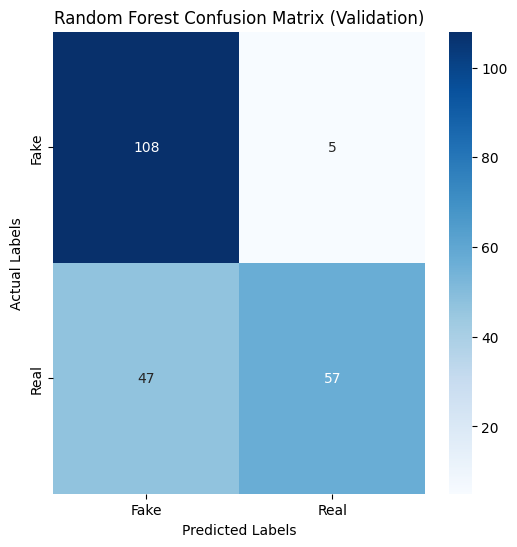


### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Logistic Regression Parameters: {'C': np.float64(6.1111501174320875), 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.93      0.92      0.92       113
        Real       0.91      0.92      0.92       104

    accuracy                           0.92       217
   macro avg       0.92      0.92      0.92       217
weighted avg       0.92      0.92      0.92       217



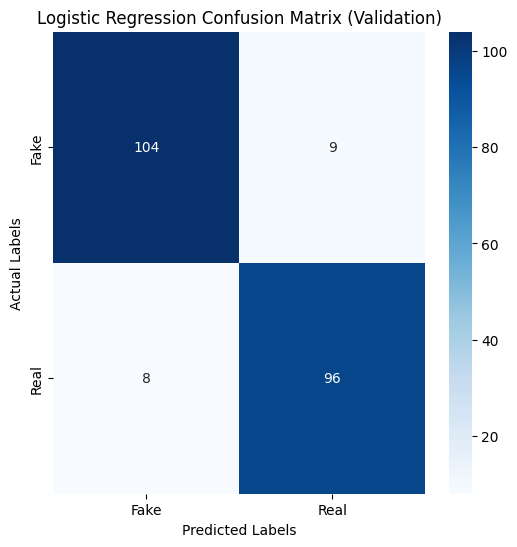


### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'C': np.float64(1.6599452033620266), 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.91      0.94      0.92       113
        Real       0.93      0.89      0.91       104

    accuracy                           0.92       217
   macro avg       0.92      0.92      0.92       217
weighted avg       0.92      0.92      0.92       217



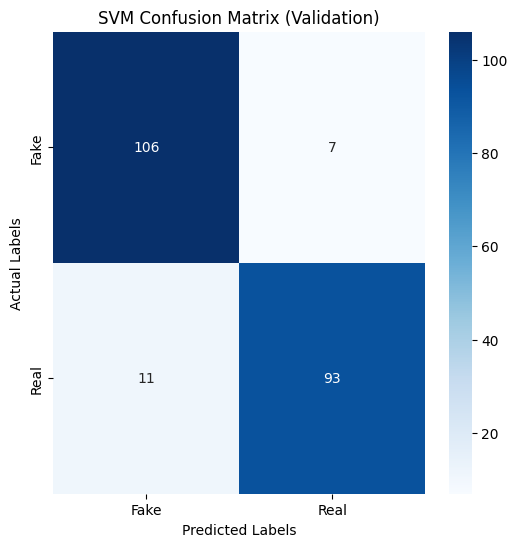


### Final Evaluation on Test Data ###
Random Forest Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.70      0.95      0.80       114
        Real       0.90      0.54      0.68       103

    accuracy                           0.76       217
   macro avg       0.80      0.75      0.74       217
weighted avg       0.79      0.76      0.74       217



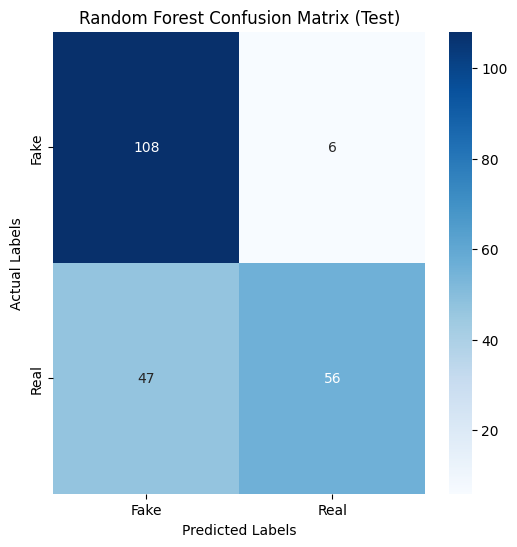

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.96      0.94       114
        Real       0.95      0.92      0.94       103

    accuracy                           0.94       217
   macro avg       0.94      0.94      0.94       217
weighted avg       0.94      0.94      0.94       217



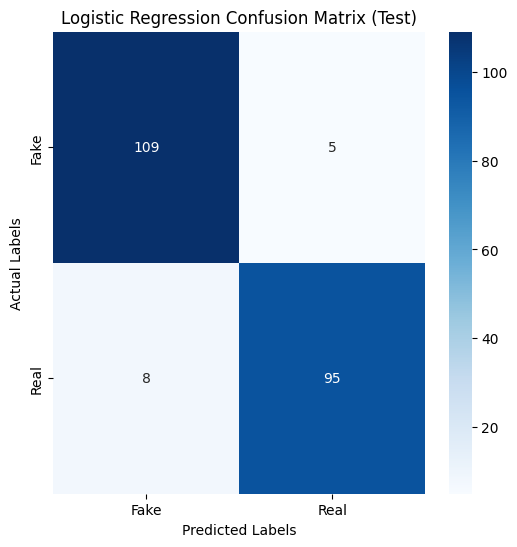

SVM Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.92      0.96      0.94       114
        Real       0.95      0.90      0.93       103

    accuracy                           0.93       217
   macro avg       0.93      0.93      0.93       217
weighted avg       0.93      0.93      0.93       217



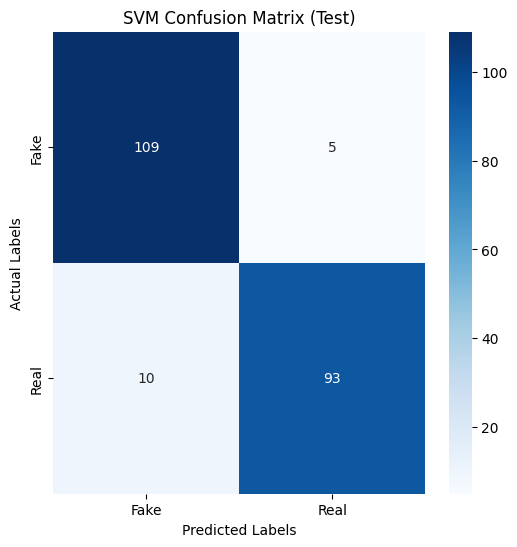


### Processing Feature Combination: TEXTURE_COLOR ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 70}
Random Forest Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.96      0.95      0.96       113
        Real       0.94      0.96      0.95       104

    accuracy                           0.95       217
   macro avg       0.95      0.95      0.95       217
weighted avg       0.95      0.95      0.95       217



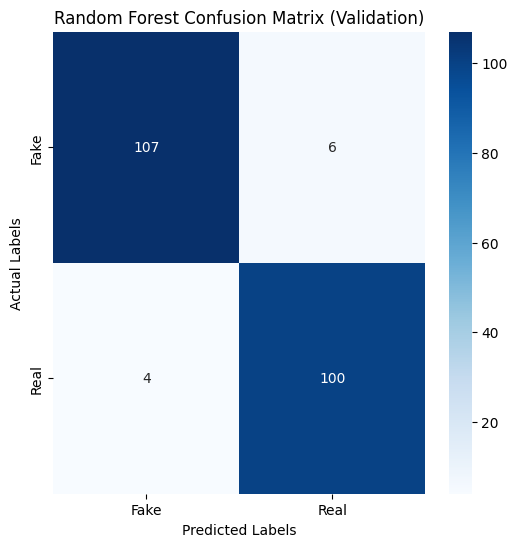


### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Logistic Regression Parameters: {'C': np.float64(3.845401188473625), 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.85      0.96      0.90       113
        Real       0.96      0.82      0.88       104

    accuracy                           0.89       217
   macro avg       0.90      0.89      0.89       217
weighted avg       0.90      0.89      0.89       217



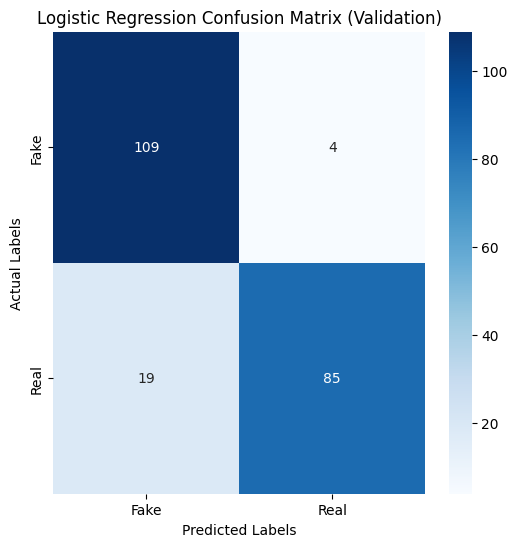


### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'C': np.float64(1.9182496720710063), 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.89      0.99      0.94       113
        Real       0.99      0.87      0.92       104

    accuracy                           0.93       217
   macro avg       0.94      0.93      0.93       217
weighted avg       0.94      0.93      0.93       217



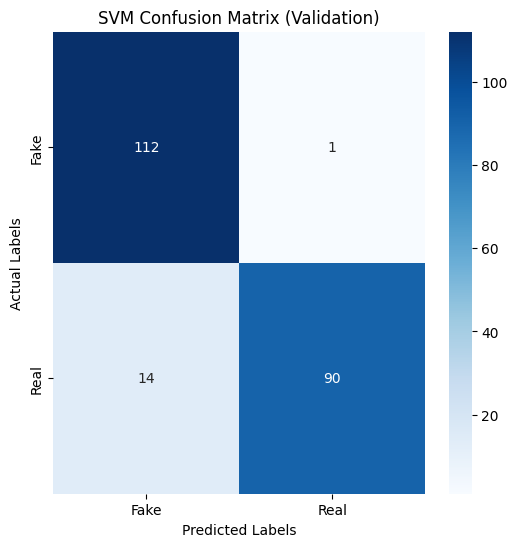


### Final Evaluation on Test Data ###
Random Forest Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.96      0.96       114
        Real       0.96      0.96      0.96       103

    accuracy                           0.96       217
   macro avg       0.96      0.96      0.96       217
weighted avg       0.96      0.96      0.96       217



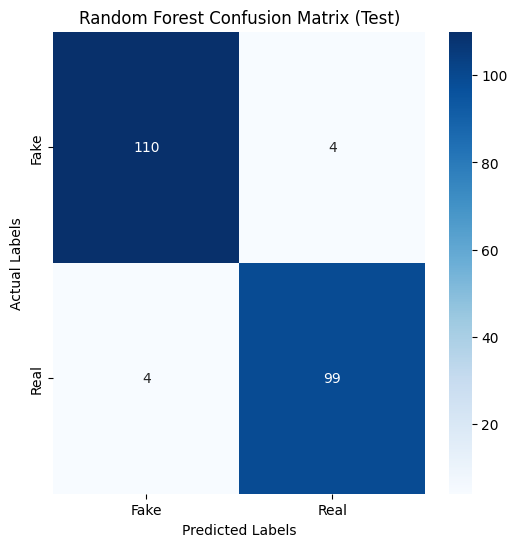

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.81      0.97      0.88       114
        Real       0.96      0.75      0.84       103

    accuracy                           0.87       217
   macro avg       0.89      0.86      0.86       217
weighted avg       0.88      0.87      0.86       217



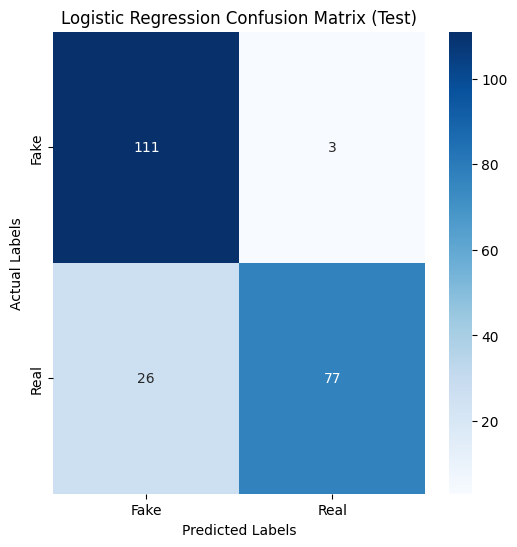

SVM Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.87      0.98      0.92       114
        Real       0.98      0.83      0.90       103

    accuracy                           0.91       217
   macro avg       0.92      0.91      0.91       217
weighted avg       0.92      0.91      0.91       217



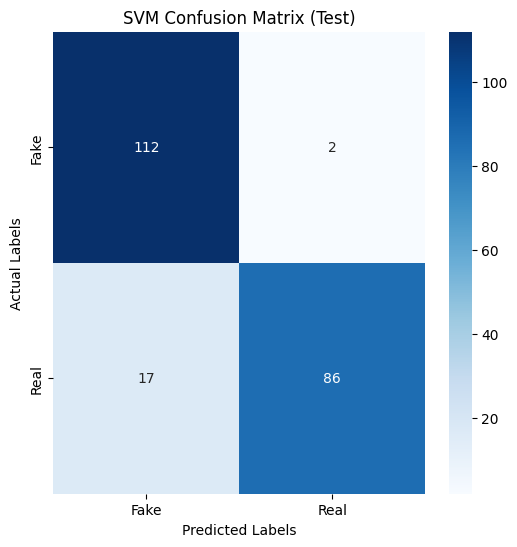


### Processing Feature Combination: SHAPE_COLOR ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 39, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 253}
Random Forest Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.84      0.97      0.90       113
        Real       0.97      0.80      0.87       104

    accuracy                           0.89       217
   macro avg       0.90      0.89      0.89       217
weighted avg       0.90      0.89      0.89       217



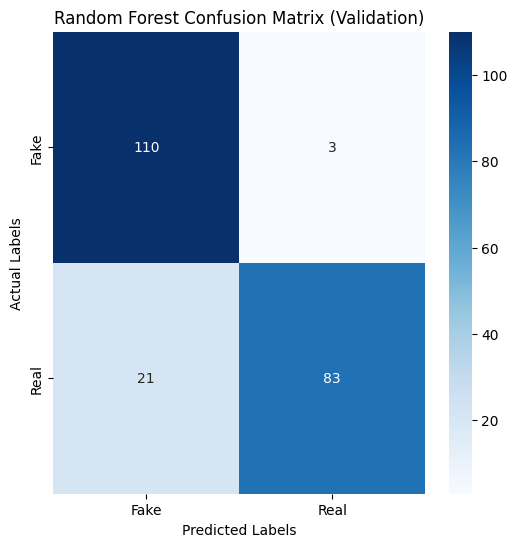


### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Logistic Regression Parameters: {'C': np.float64(1.6601864044243653), 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.91      0.94      0.92       113
        Real       0.93      0.89      0.91       104

    accuracy                           0.92       217
   macro avg       0.92      0.92      0.92       217
weighted avg       0.92      0.92      0.92       217



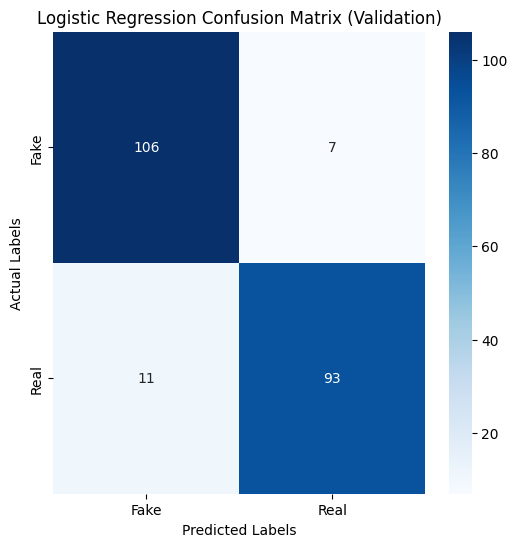


### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'C': np.float64(1.6599452033620266), 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.92      0.92      0.92       113
        Real       0.91      0.91      0.91       104

    accuracy                           0.92       217
   macro avg       0.92      0.92      0.92       217
weighted avg       0.92      0.92      0.92       217



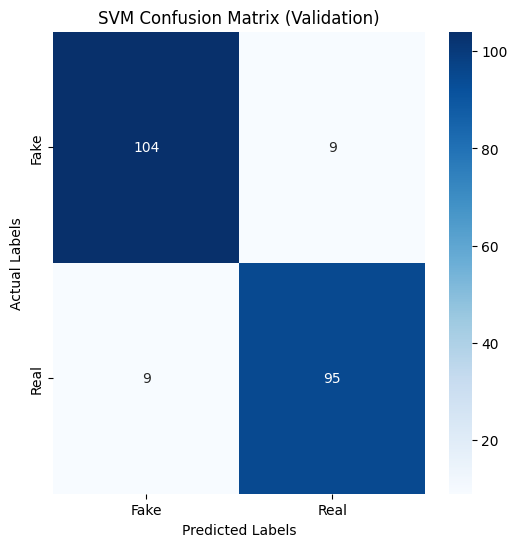


### Final Evaluation on Test Data ###
Random Forest Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.90      0.98      0.94       114
        Real       0.98      0.88      0.93       103

    accuracy                           0.94       217
   macro avg       0.94      0.93      0.93       217
weighted avg       0.94      0.94      0.94       217



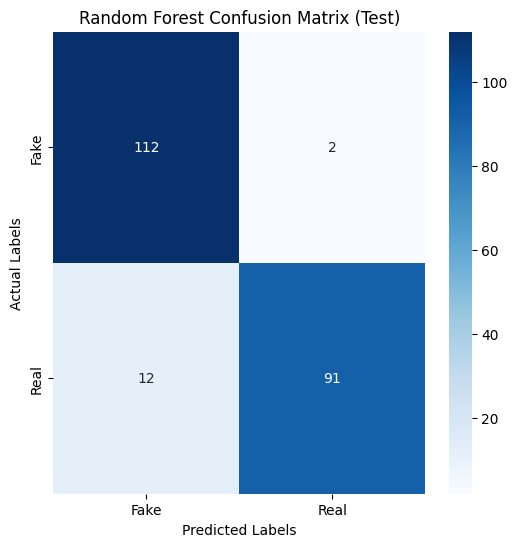

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.94      0.96      0.95       114
        Real       0.95      0.93      0.94       103

    accuracy                           0.94       217
   macro avg       0.95      0.94      0.94       217
weighted avg       0.94      0.94      0.94       217



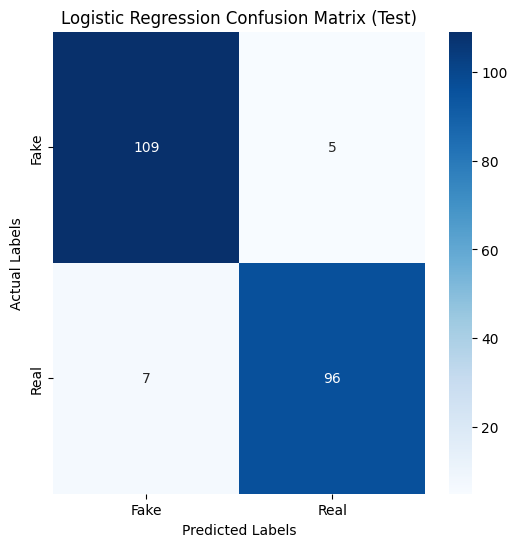

SVM Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.95      0.97      0.96       114
        Real       0.97      0.94      0.96       103

    accuracy                           0.96       217
   macro avg       0.96      0.96      0.96       217
weighted avg       0.96      0.96      0.96       217



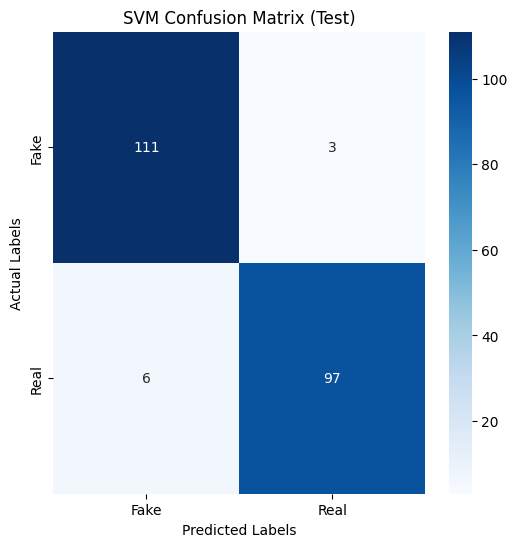


### Processing Feature Combination: TEXTURE_SHAPE_COLOR ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 70}
Random Forest Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.89      0.96      0.92       113
        Real       0.96      0.87      0.91       104

    accuracy                           0.92       217
   macro avg       0.92      0.91      0.92       217
weighted avg       0.92      0.92      0.92       217



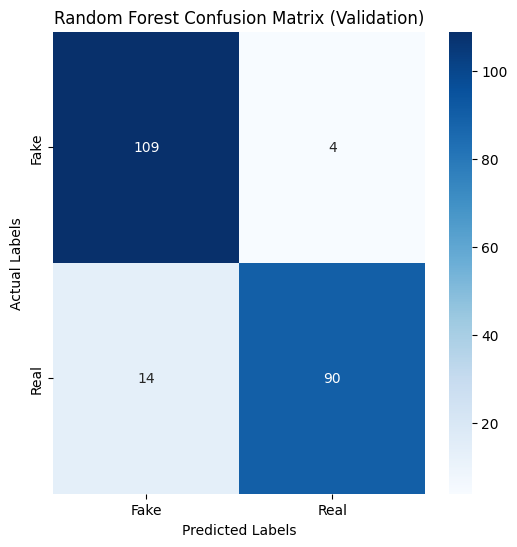


### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Logistic Regression Parameters: {'C': np.float64(1.9182496720710063), 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.92      0.96      0.94       113
        Real       0.95      0.91      0.93       104

    accuracy                           0.94       217
   macro avg       0.94      0.93      0.94       217
weighted avg       0.94      0.94      0.94       217



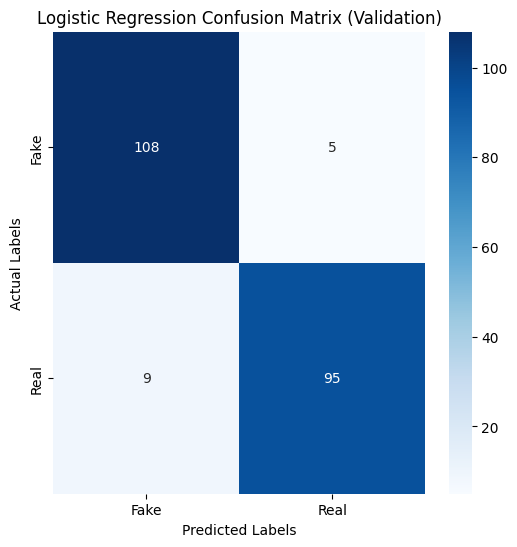


### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM Parameters: {'C': np.float64(1.6599452033620266), 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classification Report (Validation):
              precision    recall  f1-score   support

        Fake       0.93      0.94      0.93       113
        Real       0.93      0.92      0.93       104

    accuracy                           0.93       217
   macro avg       0.93      0.93      0.93       217
weighted avg       0.93      0.93      0.93       217



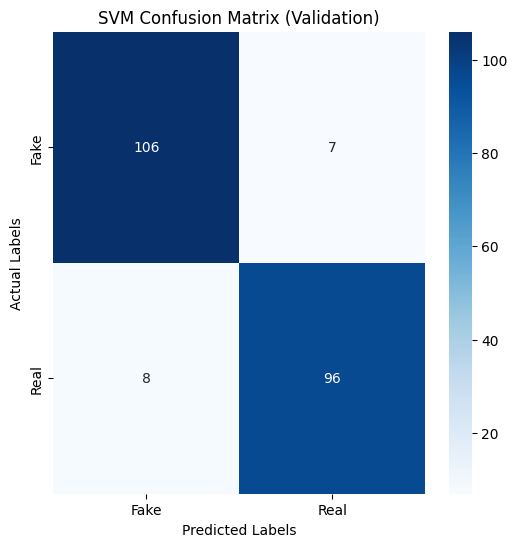


### Final Evaluation on Test Data ###
Random Forest Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.88      0.97      0.93       114
        Real       0.97      0.85      0.91       103

    accuracy                           0.92       217
   macro avg       0.92      0.91      0.92       217
weighted avg       0.92      0.92      0.92       217



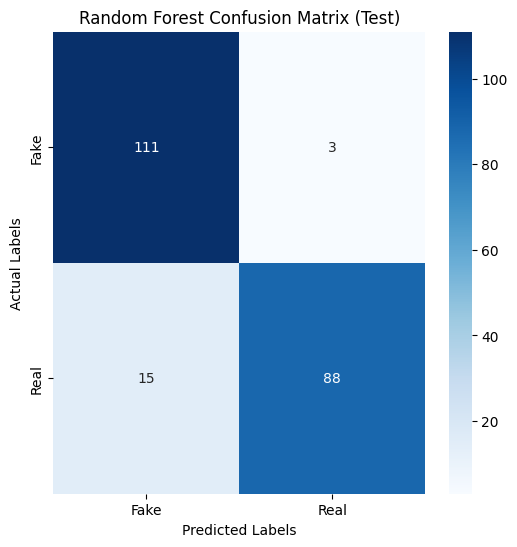

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.92      0.96      0.94       114
        Real       0.96      0.91      0.94       103

    accuracy                           0.94       217
   macro avg       0.94      0.94      0.94       217
weighted avg       0.94      0.94      0.94       217



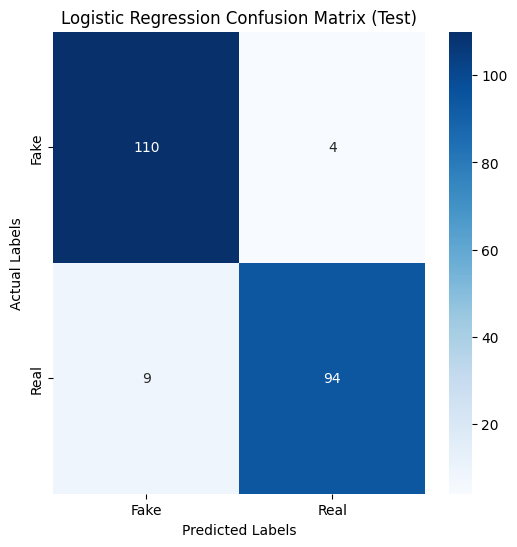

SVM Test Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.96      0.95       114
        Real       0.96      0.92      0.94       103

    accuracy                           0.94       217
   macro avg       0.95      0.94      0.94       217
weighted avg       0.95      0.94      0.94       217



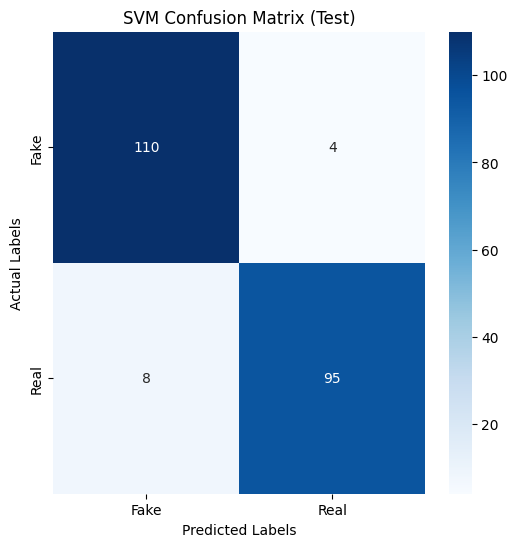

In [31]:
# Random Forest Hyperparameter Tuning
def random_forest_hyperparameter_tuning(X_train, y_train):
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    param_dist = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(10, 50),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_

# Logistic Regression Hyperparameter Tuning
def logistic_regression_hyperparameter_tuning(X_train, y_train):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    param_dist = {
        'C': uniform(0.1, 10.0),
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2'],
    }
    random_search = RandomizedSearchCV(estimator=lr, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_

# SVM Hyperparameter Tuning
def svm_hyperparameter_tuning(X_train, y_train):
    svm = SVC(probability=True, random_state=42)
    param_dist = {
        'C': uniform(0.1, 10.0),
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'],
        'degree': randint(2, 5)
    }
    random_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_, random_search.best_params_

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

# Training dan Evaluasi Model pada data validasi
def train_and_evaluate_models(X_train, X_valid, X_test, y_train, y_valid, y_test, class_names):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest
    print("\n### Random Forest Hyperparameter Tuning ###")
    best_rf_model, best_rf_params = random_forest_hyperparameter_tuning(X_train_scaled, y_train)
    print(f"Best Random Forest Parameters: {best_rf_params}")
    rf_predictions = best_rf_model.predict(X_valid_scaled)  
    print("Random Forest Classification Report (Validation):")
    print(classification_report(y_valid, rf_predictions, target_names=class_names))
    plot_confusion_matrix(y_valid, rf_predictions, class_names, "Random Forest Confusion Matrix (Validation)")

    # Logistic Regression
    print("\n### Logistic Regression Hyperparameter Tuning ###")
    best_lr_model, best_lr_params = logistic_regression_hyperparameter_tuning(X_train_scaled, y_train)
    print(f"Best Logistic Regression Parameters: {best_lr_params}")
    lr_predictions = best_lr_model.predict(X_valid_scaled)  
    print("Logistic Regression Classification Report (Validation):")
    print(classification_report(y_valid, lr_predictions, target_names=class_names))
    plot_confusion_matrix(y_valid, lr_predictions, class_names, "Logistic Regression Confusion Matrix (Validation)")

    # SVM
    print("\n### Support Vector Machine Hyperparameter Tuning ###")
    best_svm_model, best_svm_params = svm_hyperparameter_tuning(X_train_scaled, y_train)
    print(f"Best SVM Parameters: {best_svm_params}")
    svm_predictions = best_svm_model.predict(X_valid_scaled) 
    print("SVM Classification Report (Validation):")
    print(classification_report(y_valid, svm_predictions, target_names=class_names))
    plot_confusion_matrix(y_valid, svm_predictions, class_names, "SVM Confusion Matrix (Validation)")

    # Evaluasi model pada data test
    print("\n### Final Evaluation on Test Data ###")
    rf_predictions_test = best_rf_model.predict(X_test_scaled)
    lr_predictions_test = best_lr_model.predict(X_test_scaled)
    svm_predictions_test = best_svm_model.predict(X_test_scaled)

    print("Random Forest Test Classification Report:")
    print(classification_report(y_test, rf_predictions_test, target_names=class_names))
    plot_confusion_matrix(y_test, rf_predictions_test, class_names, "Random Forest Confusion Matrix (Test)")

    print("Logistic Regression Test Classification Report:")
    print(classification_report(y_test, lr_predictions_test, target_names=class_names))
    plot_confusion_matrix(y_test, lr_predictions_test, class_names, "Logistic Regression Confusion Matrix (Test)")

    print("SVM Test Classification Report:")
    print(classification_report(y_test, svm_predictions_test, target_names=class_names))
    plot_confusion_matrix(y_test, svm_predictions_test, class_names, "SVM Confusion Matrix (Test)")

# kombinasi fitur
feature_combinations = ['texture', 'shape', 'color', 'texture_shape', 'texture_color', 'shape_color', 'texture_shape_color']

# Proses pelatihan dan evaluasi data berdasarkan fitur dengan model dasar
def process_feature_combination(train_generator, validation_generator, test_generator, feature_combination):
    print(f"\n### Processing Feature Combination: {feature_combination.upper()} ###")
    
    print("Extracting features for training...")
    X_train, y_train = extract_features(train_generator, feature_combination)
    
    print("Extracting features for validation...")
    X_valid, y_valid = extract_features(validation_generator, feature_combination)
    
    print("Extracting features for testing...")
    X_test, y_test = extract_features(test_generator, feature_combination)
    
    class_names = ['Fake', 'Real']
    train_and_evaluate_models(X_train, X_valid, X_test, y_train, y_valid, y_test, class_names)

# Run proses untuk masing-masing kombinasi fitur
for combination in feature_combinations:
    process_feature_combination(train_generator, validation_generator, test_generator, combination)


# **EKSPLORASI MODEL ENSEMBLE LEARNING**


### Processing Feature Combination with Voting Classifier: TEXTURE ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Creating Voting Classifier ###

### Training Voting Classifier ###

### Voting Classifier Classification Report (Validation) ###
              precision    recall  f1-score   support

        Fake       0.88      0.94      0.91       113
        Real       0.93      0.86      0.89       104

    accuracy                           0.90       217
   macro avg       0.90      0.90      0.90       217
weighted avg       0.90      0.90      0.90       217



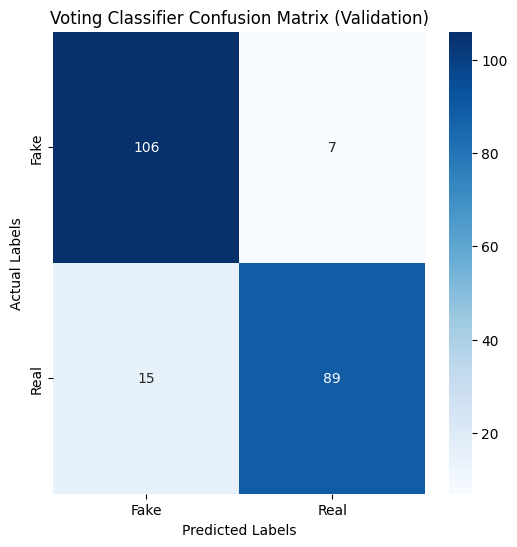


### Final Evaluation on Test Data ###

### Voting Classifier Classification Report (Test) ###
              precision    recall  f1-score   support

        Fake       0.80      0.99      0.88       114
        Real       0.99      0.72      0.83       103

    accuracy                           0.86       217
   macro avg       0.89      0.85      0.86       217
weighted avg       0.89      0.86      0.86       217



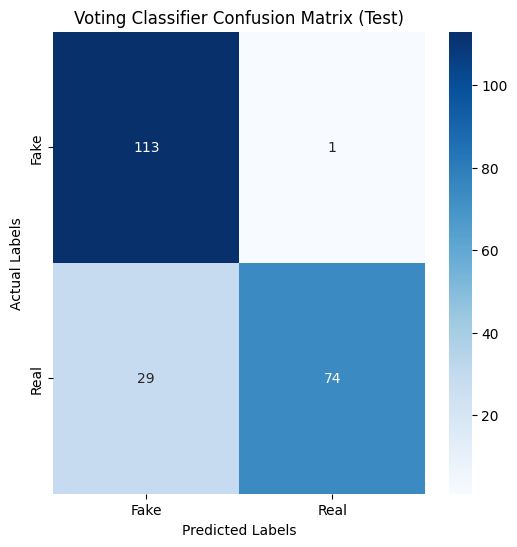


### Processing Feature Combination with Voting Classifier: SHAPE ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Creating Voting Classifier ###

### Training Voting Classifier ###


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



### Voting Classifier Classification Report (Validation) ###
              precision    recall  f1-score   support

        Fake       0.88      0.94      0.91       113
        Real       0.93      0.87      0.90       104

    accuracy                           0.90       217
   macro avg       0.91      0.90      0.90       217
weighted avg       0.90      0.90      0.90       217



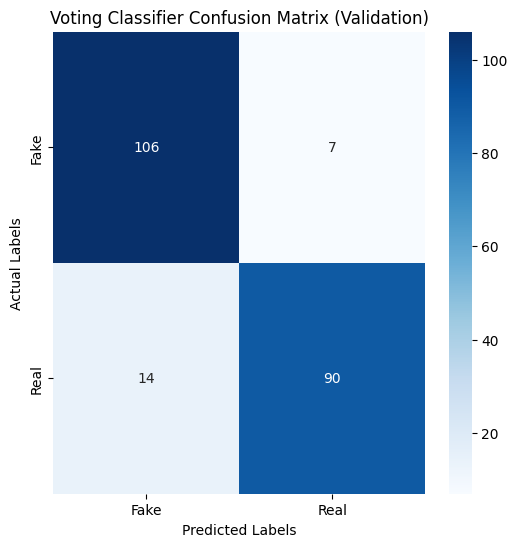


### Final Evaluation on Test Data ###

### Voting Classifier Classification Report (Test) ###
              precision    recall  f1-score   support

        Fake       0.94      0.94      0.94       114
        Real       0.93      0.93      0.93       103

    accuracy                           0.94       217
   macro avg       0.94      0.94      0.94       217
weighted avg       0.94      0.94      0.94       217



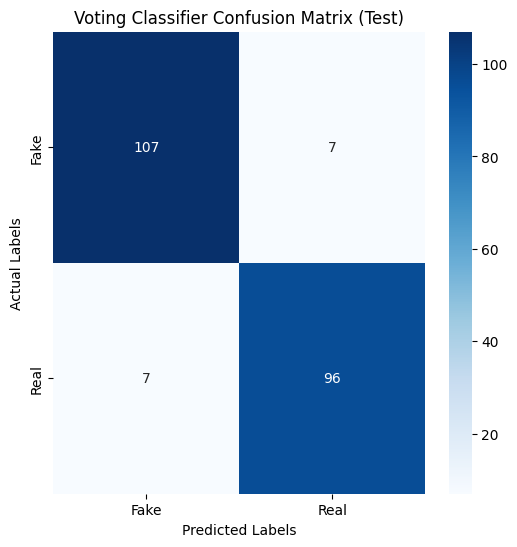


### Processing Feature Combination with Voting Classifier: COLOR ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Creating Voting Classifier ###

### Training Voting Classifier ###

### Voting Classifier Classification Report (Validation) ###
              precision    recall  f1-score   support

        Fake       0.96      0.92      0.94       113
        Real       0.92      0.96      0.94       104

    accuracy                           0.94       217
   macro avg       0.94      0.94      0.94       217
weighted avg       0.94      0.94      0.94       217



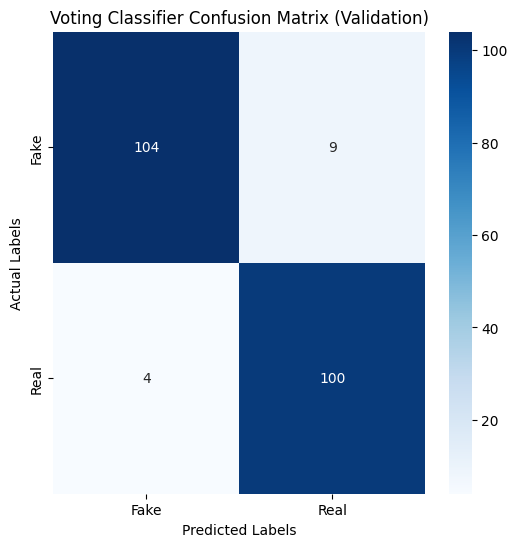


### Final Evaluation on Test Data ###

### Voting Classifier Classification Report (Test) ###
              precision    recall  f1-score   support

        Fake       0.94      0.96      0.95       114
        Real       0.96      0.93      0.95       103

    accuracy                           0.95       217
   macro avg       0.95      0.95      0.95       217
weighted avg       0.95      0.95      0.95       217



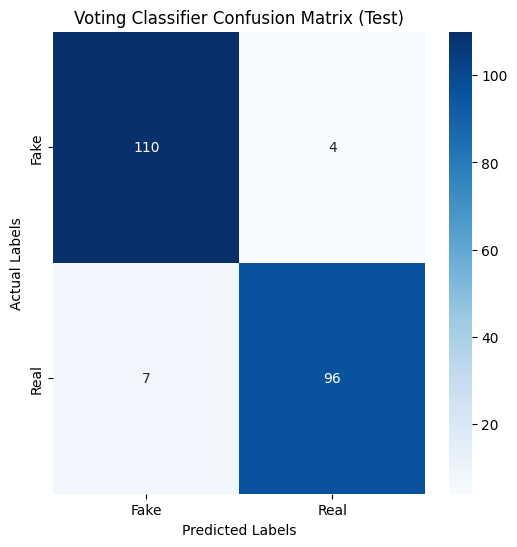


### Processing Feature Combination with Voting Classifier: TEXTURE_SHAPE ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Creating Voting Classifier ###

### Training Voting Classifier ###

### Voting Classifier Classification Report (Validation) ###
              precision    recall  f1-score   support

        Fake       0.88      0.93      0.91       113
        Real       0.92      0.87      0.89       104

    accuracy                           0.90       217
   macro avg       0.90      0.90      0.90       217
weighted avg       0.90      0.90      0.90       217



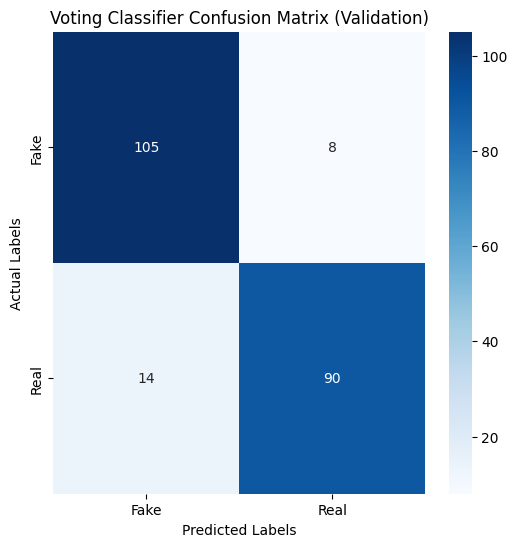


### Final Evaluation on Test Data ###

### Voting Classifier Classification Report (Test) ###
              precision    recall  f1-score   support

        Fake       0.93      0.94      0.93       114
        Real       0.93      0.92      0.93       103

    accuracy                           0.93       217
   macro avg       0.93      0.93      0.93       217
weighted avg       0.93      0.93      0.93       217



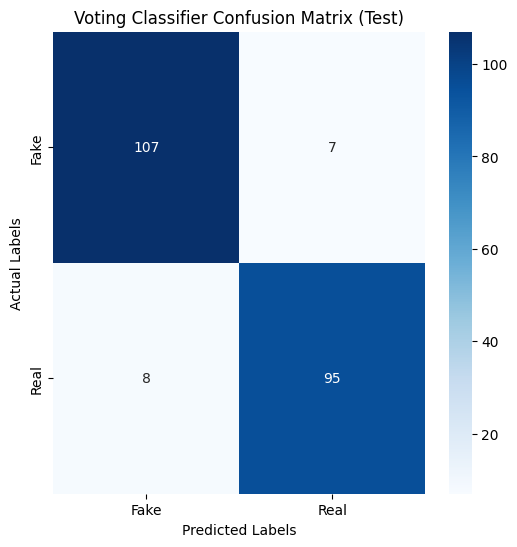


### Processing Feature Combination with Voting Classifier: TEXTURE_COLOR ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Creating Voting Classifier ###

### Training Voting Classifier ###


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



### Voting Classifier Classification Report (Validation) ###
              precision    recall  f1-score   support

        Fake       0.97      0.99      0.98       113
        Real       0.99      0.96      0.98       104

    accuracy                           0.98       217
   macro avg       0.98      0.98      0.98       217
weighted avg       0.98      0.98      0.98       217



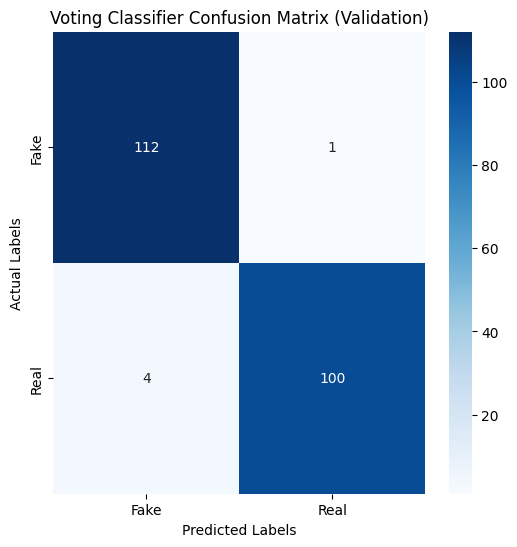


### Final Evaluation on Test Data ###

### Voting Classifier Classification Report (Test) ###
              precision    recall  f1-score   support

        Fake       0.97      0.98      0.97       114
        Real       0.98      0.96      0.97       103

    accuracy                           0.97       217
   macro avg       0.97      0.97      0.97       217
weighted avg       0.97      0.97      0.97       217



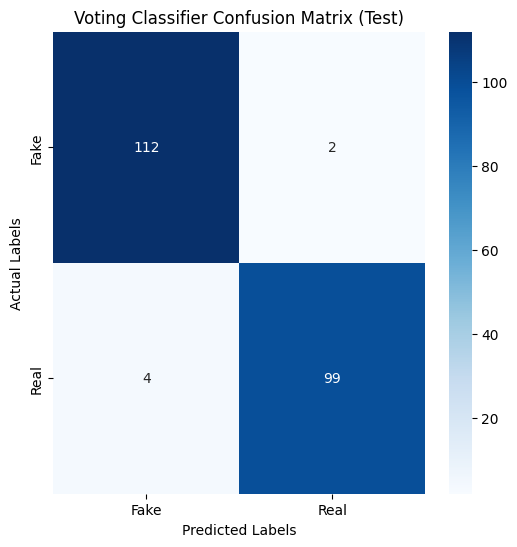


### Processing Feature Combination with Voting Classifier: SHAPE_COLOR ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Siti Vanesa Rahma\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Creating Voting Classifier ###

### Training Voting Classifier ###

### Voting Classifier Classification Report (Validation) ###
              precision    recall  f1-score   support

        Fake       0.89      0.95      0.92       113
        Real       0.94      0.88      0.91       104

    accuracy                           0.91       217
   macro avg       0.91      0.91      0.91       217
weighted avg       0.91      0.91      0.91       217



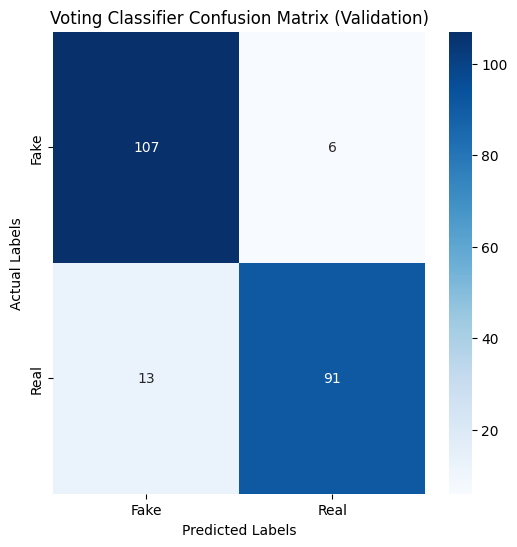


### Final Evaluation on Test Data ###

### Voting Classifier Classification Report (Test) ###
              precision    recall  f1-score   support

        Fake       0.92      0.96      0.94       114
        Real       0.96      0.90      0.93       103

    accuracy                           0.94       217
   macro avg       0.94      0.93      0.94       217
weighted avg       0.94      0.94      0.94       217



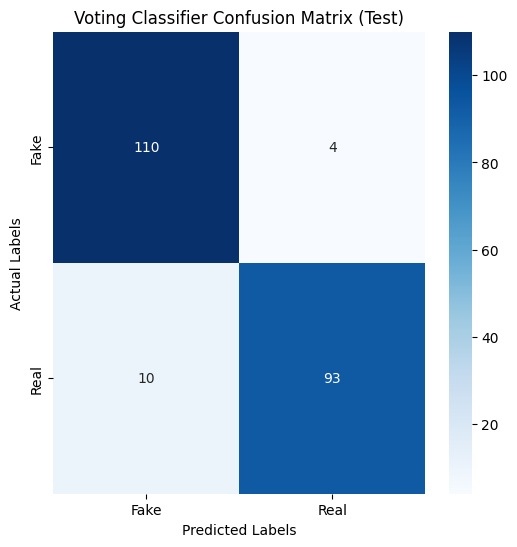


### Processing Feature Combination with Voting Classifier: TEXTURE_SHAPE_COLOR ###
Extracting features for training...
Extracting features for validation...
Extracting features for testing...

### Random Forest Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Logistic Regression Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Support Vector Machine Hyperparameter Tuning ###
Fitting 3 folds for each of 10 candidates, totalling 30 fits

### Creating Voting Classifier ###

### Training Voting Classifier ###

### Voting Classifier Classification Report (Validation) ###
              precision    recall  f1-score   support

        Fake       0.95      0.96      0.95       113
        Real       0.95      0.94      0.95       104

    accuracy                           0.95       217
   macro avg       0.95      0.95      0.95       217
weighted avg       0.95      0.95      0.95       217



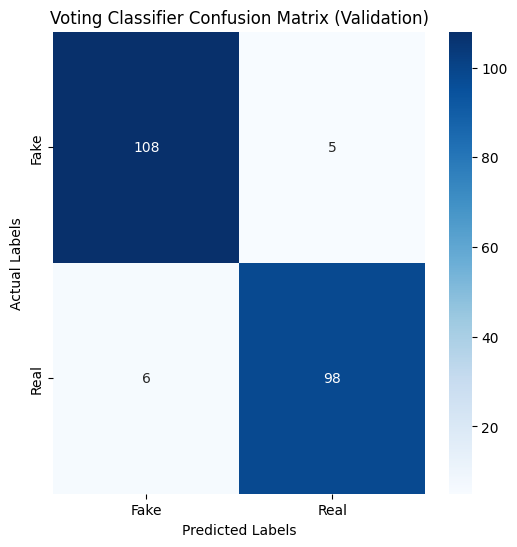


### Final Evaluation on Test Data ###

### Voting Classifier Classification Report (Test) ###
              precision    recall  f1-score   support

        Fake       0.92      0.96      0.94       114
        Real       0.95      0.91      0.93       103

    accuracy                           0.94       217
   macro avg       0.94      0.93      0.94       217
weighted avg       0.94      0.94      0.94       217



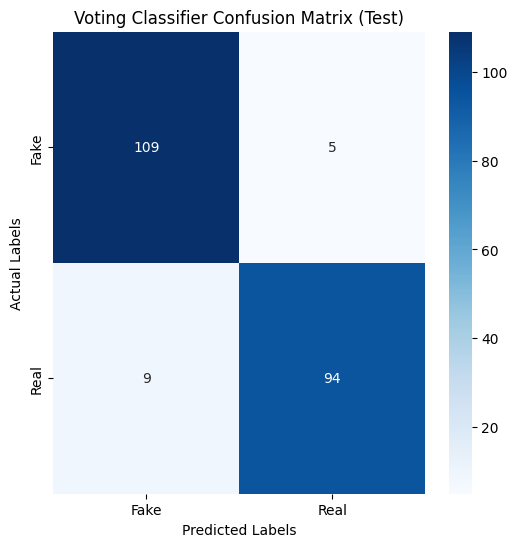

In [32]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

# Fungsi untuk melatih dan mengevaluasi voting classifier
def train_and_evaluate_voting_classifier(X_train, X_valid, X_test, y_train, y_valid, y_test, class_names):
    # Normalisasi fitur
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest
    print("\n### Random Forest Hyperparameter Tuning ###")
    best_rf_model, best_rf_params = random_forest_hyperparameter_tuning(X_train_scaled, y_train)

    # Logistic Regression
    print("\n### Logistic Regression Hyperparameter Tuning ###")
    best_lr_model, best_lr_params = logistic_regression_hyperparameter_tuning(X_train_scaled, y_train)

    # SVM
    print("\n### Support Vector Machine Hyperparameter Tuning ###")
    best_svm_model, best_svm_params = svm_hyperparameter_tuning(X_train_scaled, y_train)

    # Voting Classifier
    print("\n### Creating Voting Classifier ###")
    voting_clf = VotingClassifier(
        estimators=[
            ('Random Forest', best_rf_model),
            ('Logistic Regression', best_lr_model),
            ('SVM', best_svm_model)
        ],
        voting='hard'  # hard voting
    )

    # Training Voting Classifier
    print("\n### Training Voting Classifier ###")
    voting_clf.fit(X_train_scaled, y_train)

    # Prediksi pada data validasi
    voting_predictions_valid = voting_clf.predict(X_valid_scaled)

    # Print classification report pada validasi set
    print("\n### Voting Classifier Classification Report (Validation) ###")
    print(classification_report(y_valid, voting_predictions_valid, target_names=class_names))

    # Plot confusion matrix untuk validasi set
    plot_confusion_matrix(y_valid, voting_predictions_valid, class_names, "Voting Classifier Confusion Matrix (Validation)")

    # Evaluasi pada test dataset
    print("\n### Final Evaluation on Test Data ###")
    voting_predictions_test = voting_clf.predict(X_test_scaled)
    
    print("\n### Voting Classifier Classification Report (Test) ###")
    print(classification_report(y_test, voting_predictions_test, target_names=class_names))

    # Plot confusion matrix untuk tes set
    plot_confusion_matrix(y_test, voting_predictions_test, class_names, "Voting Classifier Confusion Matrix (Test)")

# Proses pelatihan dan evaluasi data berdasarkan fitur dengan model voting classifier
def process_feature_combination_with_voting(train_generator, validation_generator, test_generator, feature_combination):
    print(f"\n### Processing Feature Combination with Voting Classifier: {feature_combination.upper()} ###")
    
    print("Extracting features for training...")
    X_train, y_train = extract_features(train_generator, feature_combination)
    
    print("Extracting features for validation...")
    X_valid, y_valid = extract_features(validation_generator, feature_combination)
    
    print("Extracting features for testing...")
    X_test, y_test = extract_features(test_generator, feature_combination)
    
    class_names = ['Fake', 'Real']

    train_and_evaluate_voting_classifier(X_train, X_valid, X_test, y_train, y_valid, y_test, class_names)

# Run proses untuk masing-masing kombinasi fitur
for combination in feature_combinations:
    process_feature_combination_with_voting(train_generator, validation_generator, test_generator, combination)